In [20]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Configuration
DATA_ROOTS = [
    # r"/home/nigmu/NPersonal/Projects/SDP/nigmu-parkinsons_disease_prediction/Dataset/MDVR RGB",
    r"/home/nigmu/NPersonal/Projects/SDP/nigmu-parkinsons_disease_prediction/Dataset/Italian RGB 2"
]
BATCH_SIZE = 8
NUM_WORKERS = 0  # Optimize based on CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset Class
class ParkinsonSpectrogramDataset(Dataset):
    def __init__(self, root_dirs, transform=None):
        if isinstance(root_dirs, str):  # If a single path is given, convert it to a list
            root_dirs = [root_dirs]
        self.root_dirs = root_dirs
        self.transform = transform
        self.samples = self._load_samples()
        
    def _load_samples(self):
        samples = []
        for root_dir in self.root_dirs:
            for class_name in ['HC', 'PD']:
                class_dir = os.path.join(root_dir, class_name)
                if not os.path.exists(class_dir):
                    continue

                # Traverse subfolders inside HC/PD
                for patient_folder in os.listdir(class_dir):
                    patient_path = os.path.join(class_dir, patient_folder)
                    if os.path.isdir(patient_path):  # Ensure it's a directory
                        for img_file in os.listdir(patient_path):
                            if img_file.lower().endswith('.png'):  # Only PNG images
                                img_path = os.path.join(patient_path, img_file)
                                samples.append((img_path, 0 if class_name == 'HC' else 1))

        print(f"✅ Loaded {len(samples)} samples from {self.root_dirs}")
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')  # Convert to RGB
        if self.transform:
            img = self.transform(img)
        return img, label

# Data Transforms
train_transform = transforms.Compose([
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Only slight translations
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize between -1 and 1
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Create Datasets (Loading from both MDVR & Italian datasets)
train_dataset = ParkinsonSpectrogramDataset([os.path.join(root, 'train') for root in DATA_ROOTS], transform=train_transform)
val_dataset = ParkinsonSpectrogramDataset([os.path.join(root, 'val') for root in DATA_ROOTS], transform=test_transform)
test_dataset = ParkinsonSpectrogramDataset([os.path.join(root, 'test') for root in DATA_ROOTS], transform=test_transform)

# Optimized DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                          num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=False)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                        num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=False)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                         num_workers=NUM_WORKERS, pin_memory=True)

print(f"✅ DataLoaders ready! Using device: {DEVICE}")

✅ Loaded 12114 samples from ['/home/nigmu/NPersonal/Projects/SDP/nigmu-parkinsons_disease_prediction/Dataset/Italian RGB 2/train']
✅ Loaded 2364 samples from ['/home/nigmu/NPersonal/Projects/SDP/nigmu-parkinsons_disease_prediction/Dataset/Italian RGB 2/val']
✅ Loaded 4291 samples from ['/home/nigmu/NPersonal/Projects/SDP/nigmu-parkinsons_disease_prediction/Dataset/Italian RGB 2/test']
✅ DataLoaders ready! Using device: cuda


In [21]:
# 🚀 Full Pipeline for Pretrained DenseNet121 with RGB Spectrograms

import os
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
from tqdm import tqdm

# ============================
# ✅ Configuration
# ============================
# DATA_DIR = "/home/nigmu/NPersonal/Projects/SDP/nigmu-parkinsons_disease_prediction/Dataset/MDVR RGB"
# DATA_DIR = "/home/nigmu/NPersonal/Projects/SDP/nigmu-parkinsons_disease_prediction/Dataset/Italian RGB"
# BATCH_SIZE = 32
NUM_CLASSES = 2
EPOCHS = 100
LEARNING_RATE = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================
# ✅ Data Transforms
# ============================
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize from (496x200) to 224x224 for DenseNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# ============================
# ✅ Dataset and DataLoader
# ============================
# train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'train'), transform=transform)
# val_dataset   = datasets.ImageFolder(os.path.join(DATA_DIR, 'val'), transform=transform)
# test_dataset  = datasets.ImageFolder(os.path.join(DATA_DIR, 'test'), transform=transform)

# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
# val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
# test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# ============================
# ✅ Model Definition
# ============================


# # mFrom here 
class CustomDenseNet121(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(CustomDenseNet121, self).__init__()
        base_model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)

        self.features = base_model.features  # All layers up to final conv
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # Global Average Pooling
        self.fc1 = nn.Linear(base_model.classifier.in_features, 128)
        self.relu = nn.ReLU()
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.classifier(x)
        return x

model = CustomDenseNet121(num_classes=NUM_CLASSES).to(DEVICE)
# #To here


# # from here
# model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
# model.classifier = nn.Linear(model.classifier.in_features, NUM_CLASSES)
# model = model.to(DEVICE)
# # to here

# ============================
# ✅ Loss and Optimizer
# ============================
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# ============================
# ✅ Training and Validation Loop
# ============================


# Store metrics for plotting
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_accuracy = None  # Final test accuracy



def train_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    loop = tqdm(loader, desc="Training", leave=False)
    for images, labels in loop:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=loss.item(), acc=100. * correct / total)

    return running_loss / total, correct / total

def validate_epoch(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        loop = tqdm(loader, desc="Validation", leave=False)
        for images, labels in loop:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=loss.item(), acc=100. * correct / total)

    return running_loss / total, correct / total

# ============================
# ✅ Run Training
# ============================
for epoch in range(EPOCHS):
    print(f"\n🌟 Epoch {epoch+1}/{EPOCHS}")
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion)

    # Save metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    
    print(f"\n📈 Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

# ============================
# ✅ Testing
# ============================
def test_model(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Testing"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = 100. * correct / total
    print(f"\n✅ Test Accuracy: {acc:.2f}%")
    return acc  # <- Return value for test_accuracy

# Run test
print("\n🚀 Testing best model...")
test_accuracy = test_model(model, test_loader)


🌟 Epoch 1/100



📈 Train Loss: 0.1707, Acc: 0.9332 | Val Loss: 0.2141, Acc: 0.9260

🌟 Epoch 2/100



📈 Train Loss: 0.0741, Acc: 0.9741 | Val Loss: 0.2105, Acc: 0.9429

🌟 Epoch 3/100



📈 Train Loss: 0.0506, Acc: 0.9845 | Val Loss: 0.2173, Acc: 0.9391

🌟 Epoch 4/100



📈 Train Loss: 0.0462, Acc: 0.9839 | Val Loss: 0.3509, Acc: 0.8883

🌟 Epoch 5/100



📈 Train Loss: 0.0407, Acc: 0.9856 | Val Loss: 0.1763, Acc: 0.9416

🌟 Epoch 6/100



📈 Train Loss: 0.0362, Acc: 0.9872 | Val Loss: 0.2013, Acc: 0.9530

🌟 Epoch 7/100



📈 Train Loss: 0.0319, Acc: 0.9896 | Val Loss: 0.2561, Acc: 0.9103

🌟 Epoch 8/100



📈 Train Loss: 0.0302, Acc: 0.9900 | Val Loss: 0.1296, Acc: 0.9459

🌟 Epoch 9/100



📈 Train Loss: 0.0238, Acc: 0.9922 | Val Loss: 0.2116, Acc: 0.9370

🌟 Epoch 10/100



📈 Train Loss: 0.0253, Acc: 0.9913 | Val Loss: 0.1348, Acc: 0.9653

🌟 Epoch 11/100



📈 Train Loss: 0.0177, Acc: 0.9941 | Val Loss: 0.2361, Acc: 0.9607

🌟 Epoch 12/100



📈 Train Loss: 0.0182, Acc: 0.9937 | Val Loss: 0.1352, Acc: 0.9683

🌟 Epoch 13/100



📈 Train Loss: 0.0237, Acc: 0.9918 | Val Loss: 0.1135, Acc: 0.9624

🌟 Epoch 14/100



📈 Train Loss: 0.0172, Acc: 0.9935 | Val Loss: 0.2634, Acc: 0.9306

🌟 Epoch 15/100



📈 Train Loss: 0.0187, Acc: 0.9937 | Val Loss: 0.2093, Acc: 0.9361

🌟 Epoch 16/100



📈 Train Loss: 0.0133, Acc: 0.9958 | Val Loss: 0.2507, Acc: 0.9302

🌟 Epoch 17/100



📈 Train Loss: 0.0146, Acc: 0.9955 | Val Loss: 0.1620, Acc: 0.9670

🌟 Epoch 18/100



📈 Train Loss: 0.0149, Acc: 0.9952 | Val Loss: 0.2214, Acc: 0.9514

🌟 Epoch 19/100



📈 Train Loss: 0.0128, Acc: 0.9961 | Val Loss: 0.0889, Acc: 0.9818

🌟 Epoch 20/100



📈 Train Loss: 0.0094, Acc: 0.9966 | Val Loss: 0.2099, Acc: 0.9607

🌟 Epoch 21/100



📈 Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.3406, Acc: 0.9184

🌟 Epoch 22/100



📈 Train Loss: 0.0156, Acc: 0.9955 | Val Loss: 0.2439, Acc: 0.9408

🌟 Epoch 23/100



📈 Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.3096, Acc: 0.9420

🌟 Epoch 24/100



📈 Train Loss: 0.0136, Acc: 0.9955 | Val Loss: 0.1341, Acc: 0.9657

🌟 Epoch 25/100



📈 Train Loss: 0.0109, Acc: 0.9961 | Val Loss: 0.1431, Acc: 0.9649

🌟 Epoch 26/100



📈 Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.1219, Acc: 0.9759

🌟 Epoch 27/100



📈 Train Loss: 0.0127, Acc: 0.9955 | Val Loss: 0.2220, Acc: 0.9399

🌟 Epoch 28/100



📈 Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.4167, Acc: 0.9158

🌟 Epoch 29/100



📈 Train Loss: 0.0093, Acc: 0.9974 | Val Loss: 0.2557, Acc: 0.9450

🌟 Epoch 30/100



📈 Train Loss: 0.0129, Acc: 0.9971 | Val Loss: 0.1422, Acc: 0.9683

🌟 Epoch 31/100



📈 Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.2392, Acc: 0.9505

🌟 Epoch 32/100



📈 Train Loss: 0.0113, Acc: 0.9960 | Val Loss: 0.4113, Acc: 0.9243

🌟 Epoch 33/100



📈 Train Loss: 0.0095, Acc: 0.9966 | Val Loss: 0.1711, Acc: 0.9640

🌟 Epoch 34/100



📈 Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.2161, Acc: 0.9459

🌟 Epoch 35/100



📈 Train Loss: 0.0088, Acc: 0.9973 | Val Loss: 0.5976, Acc: 0.8866

🌟 Epoch 36/100



📈 Train Loss: 0.0104, Acc: 0.9969 | Val Loss: 0.3044, Acc: 0.9429

🌟 Epoch 37/100



📈 Train Loss: 0.0104, Acc: 0.9969 | Val Loss: 0.2284, Acc: 0.9552

🌟 Epoch 38/100



📈 Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.2973, Acc: 0.9404

🌟 Epoch 39/100



📈 Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.1722, Acc: 0.9607

🌟 Epoch 40/100



📈 Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.2485, Acc: 0.9450

🌟 Epoch 41/100



📈 Train Loss: 0.0073, Acc: 0.9972 | Val Loss: 0.1983, Acc: 0.9480

🌟 Epoch 42/100



📈 Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.2435, Acc: 0.9543

🌟 Epoch 43/100



📈 Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.2028, Acc: 0.9594

🌟 Epoch 44/100



📈 Train Loss: 0.0084, Acc: 0.9970 | Val Loss: 0.2132, Acc: 0.9450

🌟 Epoch 45/100



📈 Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.2737, Acc: 0.9154

🌟 Epoch 46/100



📈 Train Loss: 0.0070, Acc: 0.9974 | Val Loss: 0.2912, Acc: 0.9416

🌟 Epoch 47/100



📈 Train Loss: 0.0080, Acc: 0.9971 | Val Loss: 0.4220, Acc: 0.9112

🌟 Epoch 48/100



📈 Train Loss: 0.0069, Acc: 0.9974 | Val Loss: 0.2270, Acc: 0.9683

🌟 Epoch 49/100



📈 Train Loss: 0.0088, Acc: 0.9974 | Val Loss: 0.4163, Acc: 0.9217

🌟 Epoch 50/100



📈 Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.2057, Acc: 0.9602

🌟 Epoch 51/100



📈 Train Loss: 0.0059, Acc: 0.9976 | Val Loss: 0.3534, Acc: 0.9255

🌟 Epoch 52/100



📈 Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.2307, Acc: 0.9505

🌟 Epoch 53/100



📈 Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.1793, Acc: 0.9683

🌟 Epoch 54/100



📈 Train Loss: 0.0090, Acc: 0.9974 | Val Loss: 0.2823, Acc: 0.9467

🌟 Epoch 55/100



📈 Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1806, Acc: 0.9687

🌟 Epoch 56/100



📈 Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.2862, Acc: 0.9425

🌟 Epoch 57/100



📈 Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.2783, Acc: 0.9480

🌟 Epoch 58/100



📈 Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.2736, Acc: 0.9535

🌟 Epoch 59/100



📈 Train Loss: 0.0053, Acc: 0.9980 | Val Loss: 0.2203, Acc: 0.9514

🌟 Epoch 60/100



📈 Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.2347, Acc: 0.9530

🌟 Epoch 61/100



📈 Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.2418, Acc: 0.9387

🌟 Epoch 62/100



📈 Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.3063, Acc: 0.9336

🌟 Epoch 63/100



📈 Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.2026, Acc: 0.9547

🌟 Epoch 64/100



📈 Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.2698, Acc: 0.9467

🌟 Epoch 65/100



📈 Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.2038, Acc: 0.9412

🌟 Epoch 66/100



📈 Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.2319, Acc: 0.9488

🌟 Epoch 67/100



📈 Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1896, Acc: 0.9640

🌟 Epoch 68/100



📈 Train Loss: 0.0036, Acc: 0.9985 | Val Loss: 0.3054, Acc: 0.9353

🌟 Epoch 69/100



📈 Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1864, Acc: 0.9657

🌟 Epoch 70/100



📈 Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.3473, Acc: 0.9416

🌟 Epoch 71/100



📈 Train Loss: 0.0101, Acc: 0.9975 | Val Loss: 0.1530, Acc: 0.9738

🌟 Epoch 72/100



📈 Train Loss: 0.0053, Acc: 0.9979 | Val Loss: 0.0905, Acc: 0.9772

🌟 Epoch 73/100



📈 Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.2641, Acc: 0.9492

🌟 Epoch 74/100



📈 Train Loss: 0.0069, Acc: 0.9974 | Val Loss: 0.2041, Acc: 0.9552

🌟 Epoch 75/100



📈 Train Loss: 0.0030, Acc: 0.9993 | Val Loss: 0.1782, Acc: 0.9649

🌟 Epoch 76/100



📈 Train Loss: 0.0062, Acc: 0.9976 | Val Loss: 0.3294, Acc: 0.9518

🌟 Epoch 77/100



📈 Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.4316, Acc: 0.9370

🌟 Epoch 78/100



📈 Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.2686, Acc: 0.9569

🌟 Epoch 79/100



📈 Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.2873, Acc: 0.9488

🌟 Epoch 80/100



📈 Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.2870, Acc: 0.9429

🌟 Epoch 81/100



📈 Train Loss: 0.0036, Acc: 0.9986 | Val Loss: 0.2449, Acc: 0.9670

🌟 Epoch 82/100



📈 Train Loss: 0.0043, Acc: 0.9990 | Val Loss: 0.2751, Acc: 0.9590

🌟 Epoch 83/100



📈 Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.3188, Acc: 0.9459

🌟 Epoch 84/100



📈 Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.3480, Acc: 0.9365

🌟 Epoch 85/100



📈 Train Loss: 0.0032, Acc: 0.9987 | Val Loss: 0.4703, Acc: 0.9209

🌟 Epoch 86/100



📈 Train Loss: 0.0057, Acc: 0.9979 | Val Loss: 0.5958, Acc: 0.8777

🌟 Epoch 87/100



📈 Train Loss: 0.0053, Acc: 0.9988 | Val Loss: 0.2089, Acc: 0.9653

🌟 Epoch 88/100



📈 Train Loss: 0.0038, Acc: 0.9985 | Val Loss: 0.1488, Acc: 0.9712

🌟 Epoch 89/100



📈 Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0902, Acc: 0.9759

🌟 Epoch 90/100



📈 Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.2048, Acc: 0.9518

🌟 Epoch 91/100



📈 Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.2793, Acc: 0.9530

🌟 Epoch 92/100



📈 Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.2541, Acc: 0.9433

🌟 Epoch 93/100



📈 Train Loss: 0.0012, Acc: 0.9994 | Val Loss: 0.4708, Acc: 0.9234

🌟 Epoch 94/100



📈 Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.3136, Acc: 0.9463

🌟 Epoch 95/100



📈 Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.4203, Acc: 0.9196

🌟 Epoch 96/100



📈 Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.2274, Acc: 0.9518

🌟 Epoch 97/100



📈 Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.3544, Acc: 0.9374

🌟 Epoch 98/100



📈 Train Loss: 0.0025, Acc: 0.9995 | Val Loss: 0.2896, Acc: 0.9530

🌟 Epoch 99/100



📈 Train Loss: 0.0045, Acc: 0.9992 | Val Loss: 0.3143, Acc: 0.9484

🌟 Epoch 100/100



📈 Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.3383, Acc: 0.9509

🚀 Testing best model...


Testing: 100%|████████████████████████████████| 537/537 [00:26<00:00, 20.03it/s]


✅ Test Accuracy: 97.02%


In [22]:
# Save the trained model
torch.save(model.state_dict(), 'best_model6.pth')
print("✅ Model saved as 'best_model6.pth'")

✅ Model saved as 'best_model6.pth'



🚀 Testing best model...


Testing: 100%|████████████████████████████████| 537/537 [00:27<00:00, 19.82it/s]



✅ Test Accuracy: 97.02%


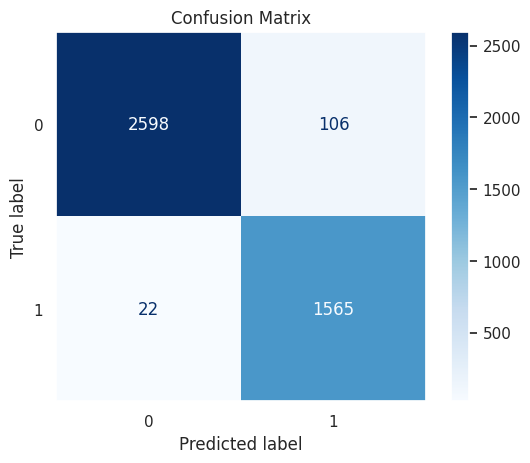


📊 Classification Report:
              precision    recall  f1-score   support

           0     0.9916    0.9608    0.9760      2704
           1     0.9366    0.9861    0.9607      1587

    accuracy                         0.9702      4291
   macro avg     0.9641    0.9735    0.9683      4291
weighted avg     0.9712    0.9702    0.9703      4291



In [23]:
import torch
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

# ============================
# ✅ Configuration
# ============================
NUM_CLASSES = 2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================
# ✅ Load model architecture
# ============================
class CustomDenseNet121(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomDenseNet121, self).__init__()
        base_model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)

        self.features = base_model.features
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(base_model.classifier.in_features, 128)
        self.relu = nn.ReLU()
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.classifier(x)
        return x

# ============================
# ✅ Initialize model
# ============================
model6 = CustomDenseNet121(num_classes=2).to(DEVICE)

# ============================
# ✅ Load the weights
# ============================
model6.load_state_dict(torch.load("best_model6.pth"))
model6.eval()

# ============================
# ✅ Test function
# ============================
def test_model6(model, loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Testing"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = 100. * correct / total
    print(f"\n✅ Test Accuracy: {acc:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()

    # Classification Report
    print("\n📊 Classification Report:")
    print(classification_report(all_labels, all_preds, digits=4))

# ============================
# ✅ Test the model
# ============================
print("\n🚀 Testing best model...")
test_model6(model6, test_loader)


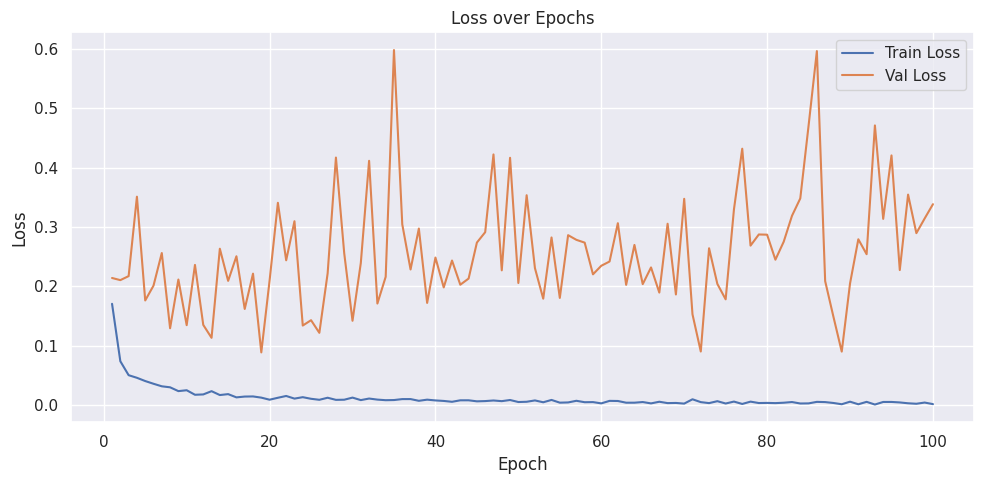

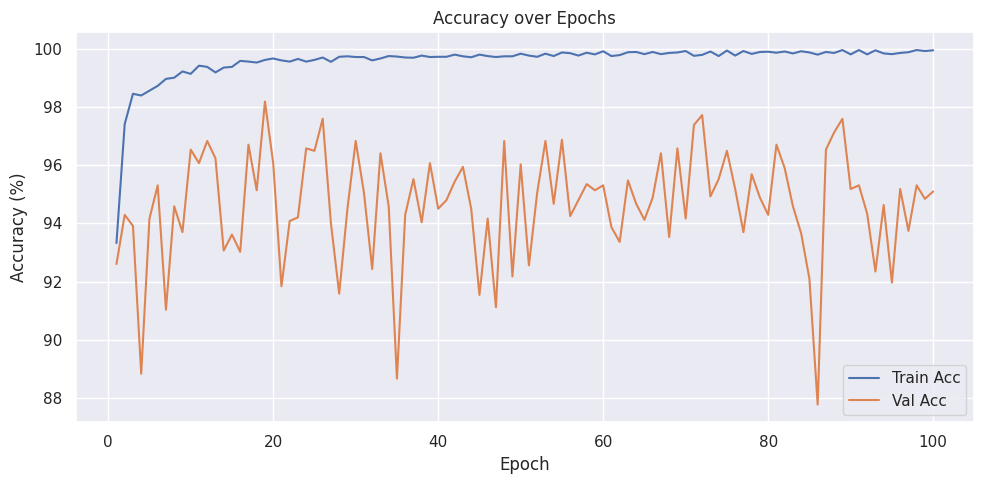

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the Seaborn “darkgrid” theme
sns.set_theme(style="darkgrid")

# Now your original plotting code works:
epochs_range = range(1, EPOCHS + 1)

# 🔹 Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses,   label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# 🔹 Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, [a * 100 for a in train_accuracies], label='Train Acc')
plt.plot(epochs_range, [a * 100 for a in val_accuracies],   label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()